# Generative models project

In [ ]:
!git clone https://github.com/NVlabs/RED-diff.git
!git clone https://github.com/VinAIResearch/blur-kernel-space-exploring bkse
!git clone https://github.com/LeviBorodenko/motionblur motion_blur
!cp -r RED-diff/models/guided_diffusion guided_diffusion_red
!cp -r RED-diff/utils utils
!wget -nc -O ffhq256-1k-validation.zip 'https://www.dropbox.com/scl/fi/pppstbdsf0em6o0qscruc/ffhq256-1k-validation.zip?rlkey=xl7nwv2nxb6yvsirr3wad77hm'
!unzip -nq ffhq256-1k-validation.zip

fatal: destination path 'RED-diff' already exists and is not an empty directory.
fatal: destination path 'bkse' already exists and is not an empty directory.
fatal: destination path 'motion_blur' already exists and is not an empty directory.
File ‘ffhq256-1k-validation.zip’ already there; not retrieving.


In [ ]:
# loads the models
!wget -nc -O cond_256.pt 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion.pt'
!wget -nc -O classifier.pt 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_classifier.pt'

# Utils functions

In [ ]:
import torch
import torchvision
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from guided_diffusion_red.script_util import create_model, create_classifier, classifier_defaults
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda:0


Image 00239


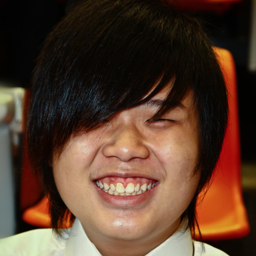

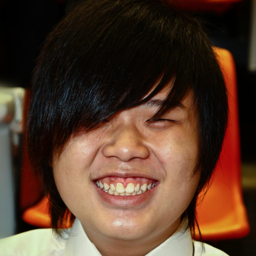

In [ ]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t):
  t = 0.5+0.5*t.to('cpu')
  t = t.squeeze()
  t = t.clamp(0.,1.)
  pil_img = torchvision.transforms.ToPILImage()(t)
  display(pil_img)
  return(pil_img)

idx = np.random.randint(1000)
print('Image', str(idx).zfill(5))
img_pil = Image.open('ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
display(img_pil)
display_as_pilimg(pilimg_to_tensor(img_pil));

# Create models

In [ ]:
kwargs= {"in_channels": 3,
              "out_channels": 3,
              "num_channels": 256,
              "num_heads": 4,
              "num_res_blocks": 2,
              "attention_resolutions": "32,16,8",
              "dropout": 0.0,
              "resamp_with_conv": True,
              "learn_sigma": True,
              "use_scale_shift_norm": True,
              "use_fp16": True,
              "resblock_updown": True,
              "num_heads_upsample": -1,
              "var_type": 'fixedsmall',
              "num_head_channels": 64,
              "image_size": 256,
              "class_cond": True,
              "use_checkpoint": True,
              "use_new_attention_order": False,
              "ckpt": "cond_1.pt"}


model = create_model(**kwargs)
model.load_state_dict(torch.load("cond_256.pt", map_location=device))
model.eval();
model=model.to(device)


In [ ]:
kwargs = classifier_defaults()
kwargs["image_size"]= 256
classifier = create_classifier(**kwargs)
classifier.load_state_dict(torch.load("classifier.pt", map_location=device))
classifier.eval();
classifier = classifier.to(device)

# Inpainting

In [ ]:
!pip install omegaconf
from utils.degredations import Inpainting2

In [ ]:
idx = 3

In [ ]:
x_true_pil = Image.open('ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)

In [ ]:
h = 256
w = 256
imgshape = x_true.shape
hcrop, wcrop = h//2, w//2
corner_top, corner_left = h//4, int(0.45*w)
mask = torch.ones(imgshape, device=device)
mask[:,:,corner_top:corner_top+hcrop,corner_left:corner_left+wcrop] = 0

In [ ]:
channels = 3
img_dim = 256
dense_masks = mask
print(dense_masks.shape)
H = Inpainting2(channels, img_dim, dense_masks, device)
H.set_indices(torch.tensor([0]).long())

torch.Size([1, 3, 256, 256])


In [ ]:
y = H.H(x_true.clone())
y.shape
y = y.to(device)


#PGDM

In [ ]:
import torch.nn.functional as F

class PGDM_DDIM:
  def __init__(self,H, model=model, classifier = None, eta = 1, inpainting = True):
    self.num_diffusion_timesteps = 100
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    self.s_list = list(self.reversed_time_steps[1:]) + [-1]
    beta_start = 0.0001
    beta_end = 0.02
    self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps,
                              dtype=np.float64)
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,3,256,256)
    self.eta = eta
    self.H = H
    self.inpainting = inpainting
    self.classifier = classifier

  def cond_fn(self, x,t, y):
      with torch.enable_grad():
          x_in = x.detach().requires_grad_(True)
          logits = self.classifier(x_in, t)
          log_probs = F.log_softmax(logits, dim=-1)
          selected = log_probs[range(len(logits)), y.view(-1)]

          return torch.autograd.grad(selected.sum(), x_in, create_graph=True)[0]

  def get_eps_from_model(self, x, t,label):
    label = torch.tensor([label], device=device)
    alpha_t = self.alphas_cumprod[t]
    timestep =  torch.tensor(t, device=device).unsqueeze(0).to(device)

    if self.classifier is None :
      model_output = self.model(x, timestep)
      model_output = model_output[:,:3,:,:]
    else:
      timestep = torch.tensor(timestep).to(device)
      model_output = self.model(x,timestep, label)[:, :3]
      model_output = model_output - np.sqrt(1 - alpha_t) * self.cond_fn(x, timestep,label)

    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def initialize(self,imgshape,y,t):
    x = torch.randn(self.imgshape,device=device)*np.sqrt(self.betas[-1])
    x.requires_grad = True
    return x

  def sample(self,y,label, x_true=None, show_steps=True, vis_y=None,):

    # initialize xt for t=T
    T = self.reversed_time_steps[-1]
    x = self.initialize(self.imgshape,y,T)
    pilimg = display_as_pilimg(x)

    x.requires_grad = True


    for i, (s,t) in enumerate(zip(self.s_list,self.reversed_time_steps)):

      n = x.size(0)
      alpha_s = self.alphas_cumprod[s]
      alpha_t = self.alphas_cumprod[t]

      c1 = np.sqrt((1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)) * self.eta
      c2 = np.sqrt((1 - alpha_s) - c1 ** 2)


      # predict x0
      x.requires_grad = True
      eps = self.get_eps_from_model(x,t,label)
      x0_pred= self.predict_xstart_from_eps(x,eps,t)


      mat = (self.H.H_pinv(y) - self.H.H_pinv(self.H.H(x0_pred))).reshape(n, -1)
      mat_x = (mat.detach() * x0_pred.reshape(n, -1)).sum()
      grad_term = torch.autograd.grad(outputs=mat_x,inputs=x, retain_graph=True)[0]

      x0_pred = x0_pred.detach()

      # ######### INPAINTING 2 ###################
      if self.inpainting:
        x0_pred = x0_pred * (1 - H.singulars().view(x0_pred.size())) + (y * H.singulars()).view(x0_pred.size())
        grad_term = grad_term * (1 - H.singulars().view(grad_term.size()))

      noise = torch.randn_like(x)
      x= np.sqrt(alpha_s) * x0_pred+ c1 * noise + c2 * eps.detach() + grad_term *np.sqrt(alpha_t)

      if i== len(self.s_list)-1:
        return x0_pred

      if show_steps:
       # if i%100==99 or t==10 or i==0:
       #   print('Iteration :', i, 't', t)
       #   if x_true is not None:
        pilimg = display_as_pilimg(torch.cat((x_true, x0_pred, x), dim=3))
    return(x)

Classe prédite : 681


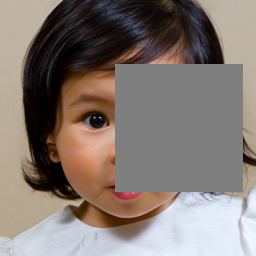

In [ ]:
  T = torch.tensor(100, device=device).unsqueeze(0)
y_reshaped = y.view(1, 3, 256, 256)


logits = classifier(y_reshaped, T)

probabilities = torch.softmax(logits, dim=1)

_, predicted_class = probabilities.max(1)
label = predicted_class.item()
print(f"Classe prédite : {label}")
display_as_pilimg(y_reshaped);

In [ ]:
print(label)

681


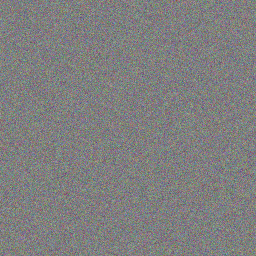

<ipython-input-17-e438aeb5bb0b>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  timestep = torch.tensor(timestep).to(device)
<ipython-input-17-e438aeb5bb0b>:75: RuntimeWarning: invalid value encountered in sqrt
  c1 = np.sqrt((1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)) * self.eta


In [ ]:
x_true = x_true.to(device)
y= y.to(device)
pgdm_ddim = PGDM_DDIM(H,model=model,classifier = classifier, eta = 1,inpainting=True)
x =pgdm_ddim.sample(y, label, x_true=x_true , show_steps=False, vis_y=None)

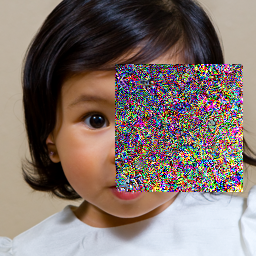

In [ ]:
x_reshaped = x.view(1,3,256,256)
display_as_pilimg(x_reshaped);

# Non linear blur

In [ ]:
from utils.degredations import NonlinearBlurOperator
import bkse


In [ ]:
opt_yml_pat = "bkse/options/generate_blur/default.yml"
current_dir = "bkse"

H = NonlinearBlurOperator(opt_yml_pat, current_dir, device)


In [ ]:
y_reshaped = y.view(1,3,256,256)
print(y_reshaped == x_true)
display_as_pilimg(y_reshaped);

In [ ]:
kwargs= {"in_channels": 3,
              "out_channels": 3,
              "num_channels": 256,
              "num_heads": 4,
              "num_res_blocks": 2,
              "attention_resolutions": "32,16,8",
              "dropout": 0.0,
              "resamp_with_conv": True,
              "learn_sigma": True,
              "use_scale_shift_norm": True,
              "use_fp16": True,
              "resblock_updown": True,
              "num_heads_upsample": -1,
              "var_type": 'fixedsmall',
              "num_head_channels": 64,
              "image_size": 256,
              "class_cond": False,
              "use_checkpoint": False,
              "use_new_attention_order": False,
              "ckpt": "cond_1.pt"}


model = create_model(**kwargs)
model.eval();
model=model.to(device)

In [ ]:
x_true = x_true.to(device)
y = H.H(x_true.clone())
y= y.to(device)

y_reshaped = y.view(1,3,256,256)

display_as_pilimg(y_reshaped);
print(y_reshaped == y)

In [ ]:
pgdm_ddim = PGDM_DDIM(H,model=model,classifier = None, eta = 1,inpainting=True)
pgdm_ddim.sample(y, label, x_true=x_true , show_steps=True, vis_y=None)